In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import loompy
import cytograph as cg 
import pandas as pd
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import TSNE

In [3]:
def loompy2data(filename):
    ds = loompy.connect(filename)
    return pd.DataFrame(data=ds[:,:], columns=ds.col_attrs['CellID'], index=ds.row_attrs['Gene']).astype(int)

def loompy2annot(filename):
    ds = loompy.connect(filename)
    return pd.DataFrame( ds.col_attrs, index=ds.col_attrs['CellID'] ).T

def loompy2data_annot(filename):
    ds = loompy.connect(filename)
    return (pd.DataFrame(data=ds[:,:],
                        columns=ds.col_attrs['CellID'],
                        index=ds.row_attrs['Gene']).astype(int),
            pd.DataFrame( ds.col_attrs,
                         index=ds.col_attrs['CellID'] ).T )

In [4]:
fname = "/data2/loom_files/development/combined/P7_cortex.loom"

In [5]:
ds = loompy.connect(fname)
sum(ds.col_attrs["Low_expression_flag"])

2017-01-15 01:38:52,855 - INFO - Connecting to: /data2/loom_files/development/combined/P7_cortex.loom


0

In [6]:
df, annotations = loompy2data_annot(fname)

2017-01-15 01:39:10,787 - INFO - Connecting to: /data2/loom_files/development/combined/P7_cortex.loom


In [7]:
low_complexity_flag = annotations.ix["Low_complexity_flag"]
low_expression_flag = annotations.ix["Low_expression_flag"]

In [8]:
included_flag = ~(low_expression_flag | low_complexity_flag)

In [9]:
df = df.ix[:,included_flag]
annotations = annotations.ix[:,included_flag]

In [10]:
sum(included_flag), len(included_flag)

(5735, 6063)

In [11]:
total_gene = np.sum(df.values,1)

In [12]:
total_expressing = (df.values>0).sum(1)

In [13]:
df = df.ix[(total_gene>8)&(total_expressing>4),:]

In [14]:
# Fitting CVvsMean noise model
mu = df.values.mean(1)
sigma = df.values.std(1, ddof=1)
cv = sigma/mu
score, mu_linspace, cv_fit , fitted_fun = cg.bi_pca.fit_CV(mu,cv, 'SVR', svr_gamma=0.005)

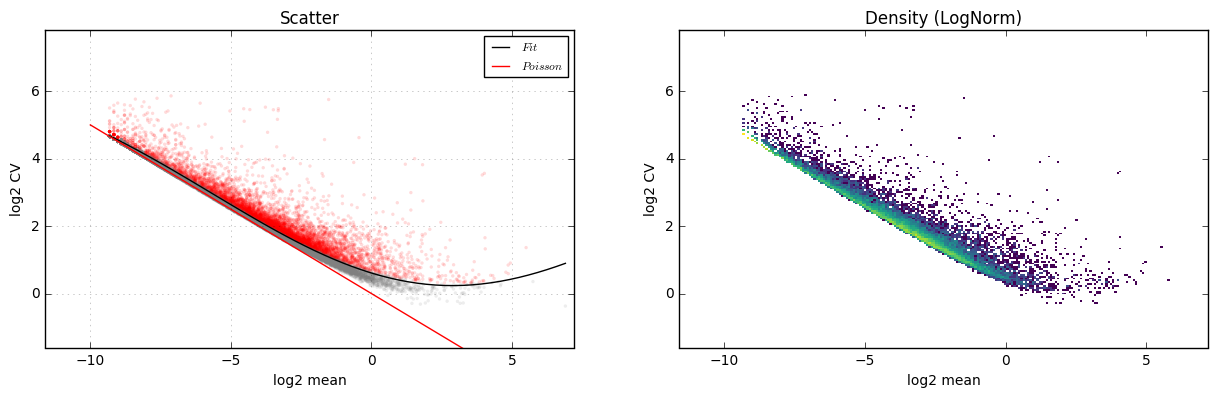

In [15]:
#Plotting
from matplotlib.colors import LogNorm
thrs = 5000
figure(figsize=(15,15))

subplot(121)

mu_sorted = mu[argsort(score)[::-1]]
cv_sorted = cv[argsort(score)[::-1]]
scatter(log2(mu_sorted[thrs:]),log2(cv_sorted[thrs:]), marker='o', edgecolor ='none',alpha=0.14, s=6, c='gray')
scatter(log2(mu_sorted[:thrs]),log2(cv_sorted[:thrs]), marker='o', edgecolor ='none',alpha=0.14, s=6, c='r')
plot(mu_linspace, cv_fit,'-k', linewidth=1, label='$Fit$')
plot(linspace(-10,7), -0.5*linspace(-10,7), '-r', label='$Poisson$')
#Adjusting plot
ylabel('log2 CV')
xlabel('log2 mean')
grid(alpha=0.3)
xlim(-11.6,7.2)
ylim(-1.6,7.8)
legend(loc=1, fontsize='small')
title('Scatter')
gca().set_aspect(1.2)

subplot(122)
hist2d(log2(mu_sorted),log2(cv_sorted), bins=[200,170],
       range=[[-9.6,6.7],[-1.6,7.8]], norm=LogNorm(),cmap=cm.viridis);
xlim(-11.6,7.2)
ylim(-1.6,7.8)
#legend(loc=1, fontsize='small')
#Adjusting plot
ylabel('log2 CV')
xlabel('log2 mean')
title('Density (LogNorm)')
gca().set_aspect(1.2)

In [16]:
feature_selected = df.index[argsort(score)[::-1]][:5000]

In [17]:
data = df.ix[feature_selected,:].values

In [21]:
data_log = np.log2(data + 1)
#data_tmp -= data_tmp.mean(1)[:, None]

In [18]:
import time
import logging
import pymc3 as pm
import theano
import scipy as sp

In [19]:
theano.config.compute_test_value = 'ignore'

<img  src="Screen Shot 2017-01-15 at 02.13.14.png" width="700"/>

In [22]:
data_log.shape

(5000, 5735)

In [24]:
N = data_log.shape[1]  # Number of samples
D = data_log.shape[0]  # Number of genes
Y = data_log.T  # Data matrix (N,D)
K = 10  # Latent dimensions
# Z = zeros((N,K)  # latent low dimensional matrix

# Low precision reflects uncertainty; prevents overfitting.
# Set to the mean variance across users and items.
alpha_u = 1. / data_log.var(axis=1).mean() 

In [26]:
varmin_Z = np.random.randn(N, K) * 0.1

In [65]:
with pm.Model() as test:
    a = pm.Normal("a",5,1)
    b = pm.NegativeBinomial("b",a,1, observed=[2,2,2,3])
    
    # Generate a MCMC chain
    #step = pm.Metropolis() # Instantiate MCMC sampling algorithm
    trace = pm.sample(1000, step=None, n_init=1000,njobs=1, progressbar=True) 

INFO (theano.gof.compilelock): Refreshing lock /home/gioele/.theano/compiledir_Linux-3.13--generic-x86_64-with-debian-jessie-sid-x86_64-3.5.2-64/lock_dir/lock
2017-01-15 02:36:15,573 - INFO - Refreshing lock /home/gioele/.theano/compiledir_Linux-3.13--generic-x86_64-with-debian-jessie-sid-x86_64-3.5.2-64/lock_dir/lock
2017-01-15 02:36:41,227 - INFO - Auto-assigning NUTS sampler...
2017-01-15 02:36:41,230 - INFO - Initializing NUTS using advi...
INFO (theano.gof.compilelock): Refreshing lock /home/gioele/.theano/compiledir_Linux-3.13--generic-x86_64-with-debian-jessie-sid-x86_64-3.5.2-64/lock_dir/lock
2017-01-15 02:37:16,389 - INFO - Refreshing lock /home/gioele/.theano/compiledir_Linux-3.13--generic-x86_64-with-debian-jessie-sid-x86_64-3.5.2-64/lock_dir/lock
Average ELBO = -8.7844: 100%|██████████| 1000/1000 [00:00<00:00, 5956.42it/s]
2017-01-15 02:37:25,625 - INFO - Finished [100%]: Average ELBO = -8.618
100%|██████████| 1000/1000 [00:01<00:00, 546.18it/s]


In [107]:
pwd

'/home/gioele/BigProject'

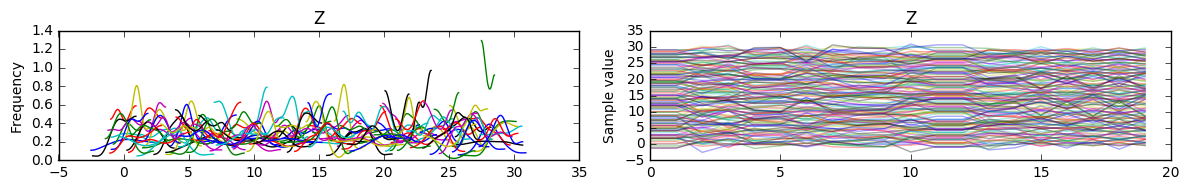

In [106]:
from pymc3 import traceplot

traceplot(trace);

In [99]:
np.arange(30)[:,None]

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29]])

In [100]:
with pm.Model() as pmf:
    Z = pm.MvNormal('Z', mu=np.arange(30)[:,None], cov=np.eye(5), shape=(30,5))
    trace = pm.sample(20, step=None, n_init=100,njobs=1, progressbar=True) 
#traceplot(trace);

2017-01-15 02:53:18,443 - INFO - Auto-assigning NUTS sampler...
2017-01-15 02:53:18,445 - INFO - Initializing NUTS using advi...
Average ELBO = 2.6255: 100%|██████████| 100/100 [00:00<00:00, 3445.49it/s]
2017-01-15 02:53:23,352 - INFO - Finished [100%]: Average ELBO = 3.008
100%|██████████| 20/20 [00:00<00:00, 120.80it/s]


In [101]:
map_estimate = pm.find_MAP(model=pmf)

Optimization terminated successfully.
         Current function value: 137.840780
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1


In [102]:
map_estimate

{'Z': array([[  0.,   0.,   0.,   0.,   0.],
        [  1.,   1.,   1.,   1.,   1.],
        [  2.,   2.,   2.,   2.,   2.],
        [  3.,   3.,   3.,   3.,   3.],
        [  4.,   4.,   4.,   4.,   4.],
        [  5.,   5.,   5.,   5.,   5.],
        [  6.,   6.,   6.,   6.,   6.],
        [  7.,   7.,   7.,   7.,   7.],
        [  8.,   8.,   8.,   8.,   8.],
        [  9.,   9.,   9.,   9.,   9.],
        [ 10.,  10.,  10.,  10.,  10.],
        [ 11.,  11.,  11.,  11.,  11.],
        [ 12.,  12.,  12.,  12.,  12.],
        [ 13.,  13.,  13.,  13.,  13.],
        [ 14.,  14.,  14.,  14.,  14.],
        [ 15.,  15.,  15.,  15.,  15.],
        [ 16.,  16.,  16.,  16.,  16.],
        [ 17.,  17.,  17.,  17.,  17.],
        [ 18.,  18.,  18.,  18.,  18.],
        [ 19.,  19.,  19.,  19.,  19.],
        [ 20.,  20.,  20.,  20.,  20.],
        [ 21.,  21.,  21.,  21.,  21.],
        [ 22.,  22.,  22.,  22.,  22.],
        [ 23.,  23.,  23.,  23.,  23.],
        [ 24.,  24.,  24.,  24.,  2

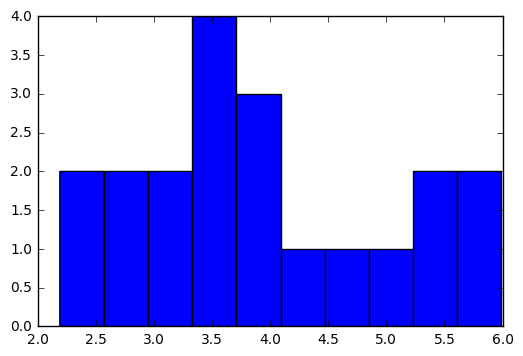

In [92]:
hist(trace["Z"][:,0,4].flat[:]);

In [82]:
trace["Z"].shape

(20, 5735, 10)

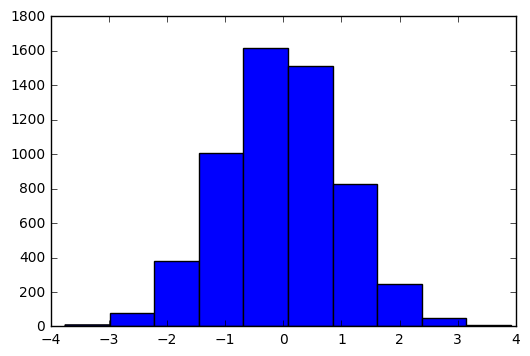

In [83]:
hist(trace["Z"][0,:,0].flat[:]);

In [29]:
with pm.Model() as pmf:
    Z = pm.MvNormal('Z', mu=0, cov=np.eye(K), shape=(N, K),
                    testval=varmin_Z)
    # A.shape=(D, K)
    # w.shape = (D,1)
    # sigmas.shape = (1,D) or (D,1)
    W = np.eye(K) * sigmas
    # mu.shape = (D,1)
    # lamda = prior_needed shape=(1,)
    X = pm.MvNormal('X', mu=np.dot(A, Z.T) + mu, cov = W, shape=(N, K),
                    testval=varmin_Z)
    p = np.exp(-lamda*X**2)
    H = pm.Bernoulli(p, shape=(N,K))
    Y = X*(1-H)

NameError: name 'w' is not defined

In [ ]:
with pm.Model() as pmf:
    
    V = pm.MvNormal('V', mu=0, tau=self.alpha_v * np.eye(dim),
                    shape=(m, dim), testval=np.random.randn(m, dim) * std)
    R = pm.Normal('R', mu=theano.tensor.dot(U, V.T), tau=self.alpha * np.ones((n, m)),
                  observed=self.data)

In [ ]:
with pm.Model() as pmf:
    U = pm.MvNormal('U', mu=0, tau=self.alpha_u * np.eye(dim),
                    shape=(n, dim), testval=np.random.randn(n, dim) * std)
    V = pm.MvNormal('V', mu=0, tau=self.alpha_v * np.eye(dim),
                    shape=(m, dim), testval=np.random.randn(m, dim) * std)
    R = pm.Normal('R', mu=theano.tensor.dot(U, V.T), tau=self.alpha * np.ones((n, m)),
                  observed=self.data)